In [14]:
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

The next snippet is used to plot the depth calculated in the script


In [16]:
def exr2depth(path):
    """Read depth image as numpy array

    Args:
        path (str): The path to the file

    Returns:
        ndarray: Returns an array with the shape WxHx1
    """
    if not os.path.isfile(path):
            return None
        
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE | cv2.IMREAD_ANYDEPTH)

    # get the maximum value from the array, aka the most distant point
    # everything above that value is infinite, thus i clamp it to maxvalue
    # then divide by maxvalue to obtain a normalized map
    # multiply by 255 to obtain a colormap from the depthmap
    maxvalue = np.max(np.where(np.isinf(img), -np.Inf, img))
    img[img > maxvalue] = maxvalue
    img = img / maxvalue * 255

    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = np.array(img).astype(np.uint8).reshape(img.shape[0], img.shape[1], -1)

    return img

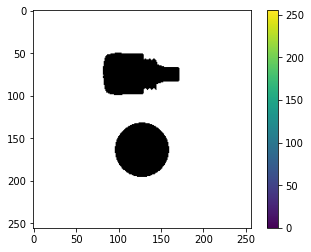

In [17]:
depth_data = exr2depth("./out/000001depth.exr")

fig = plt.figure()
plt.imshow(depth_data)
plt.colorbar()
plt.show()

The next snippet is used to plot the flow

In [18]:
def exr2flow(exr):
    """ converts 1-channel exr-data to 2D numpy arrays """ 
    img = cv2.imread(exr, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

    # Compute the size
    sz = img.shape[:2]

    R, G, B =  img[..., 0], img[..., 1], img[..., 2]

    img = np.zeros((sz[1], sz[0], 3), np.float64)
    img[:,:,0] = np.array(R).reshape(img.shape[0],-1)
    img[:,:,1] = -np.array(G).reshape(img.shape[0],-1)

    hsv = np.zeros((sz[1], sz[0], 3), np.uint8)
    hsv[...,1] = 255

    mag, ang = cv2.cartToPolar(img[...,0], img[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

    return img, bgr, mag, ang

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


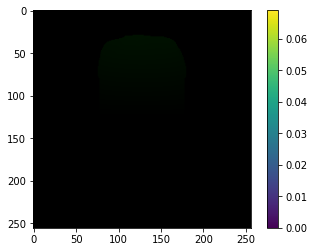

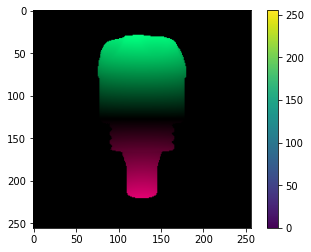

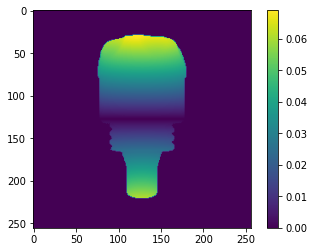

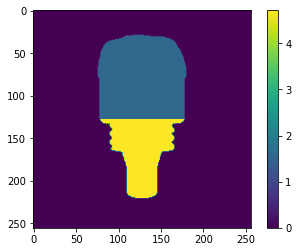

In [19]:
flow_data = exr2flow("C:/dev/tmp/vid/object01_flow0120.exr")

for data in flow_data:
    fig = plt.figure()
    plt.imshow(data)
    plt.colorbar()
    plt.show()

The next snippet is used to plot exr images


In [20]:
def exr2normal(path):
    """Read normal map image as numpy array

    Args:
        path (str): The path to the file

    Returns:
        ndarray: Returns an array with the shape WxHx3
    """
    if not os.path.isfile(path):
            return None

    img = cv2.imread(path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

    img[img > 1] = 1
    img[img < 0] = 0
    img = img * 255
    
    img = np.array(img).astype(np.uint8).reshape(img.shape[0], img.shape[1], -1)

    return img

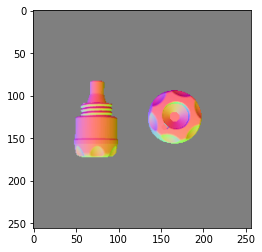

In [21]:
nrm_data = exr2normal("./out/000000normal.exr")

fig = plt.figure()
plt.imshow(nrm_data)
plt.show()

In [22]:
def exr2segmap(path):
    """Read segmentation map image as numpy array

    Args:
        path (str): The path to the file

    Returns:
        ndarray: Returns an array with the shape WxHx1
    """
    if not os.path.isfile(path):
            return None    

    img = cv2.imread(path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

    img = img[..., 0] + img[..., 1] + img[..., 2]
    img[img <= 0] = 0
    img[img > 0] = 1
    img = np.array(img).astype(np.uint8).reshape(img.shape[0], img.shape[1], -1)

    return img

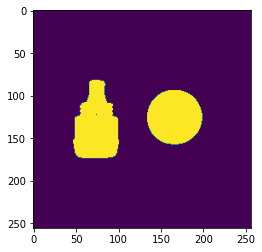

In [23]:
albedo_data = exr2segmap("./out/000000albedo.exr")

fig = plt.figure()
plt.imshow(albedo_data)
plt.show()

In [24]:
def png2rgb(path):
    """Read segmentation map image as numpy array

    Args:
        path (str): The path to the file

    Returns:
        ndarray: Returns an array with the shape WxHx1
    """
    if not os.path.isfile(path):
            return None    

    img = cv2.imread(path)

    return img

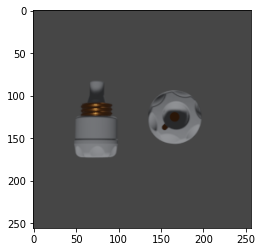

In [25]:
rgb_data = png2rgb("./out/000000rgb.png")
rgb_data = rgb_data[:, :, ::-1]

fig = plt.figure()
plt.imshow(rgb_data)
plt.show()

In [26]:
def txt2label(path):
    if not os.path.isfile(path):
        return None    

    with open(path, 'r') as f:
        l = [x.split() for x in f.read().strip().splitlines()]
        l = np.array(l, dtype=np.float32)
    
    return l

In [27]:
def xywh2xyxy(x):
    y = np.copy(x)
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
    return y


def plot_one_box(x, img, label=None):
    # Plots one bounding box on image img
    color = [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=3, lineType=cv2.LINE_AA)
    if label:
        t_size = cv2.getTextSize(label, 0, fontScale=1, thickness=2)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, 1, [225, 255, 255], thickness=3, lineType=cv2.LINE_AA)


def plot_bbox(img, labels):
    labels[:, 1:5] = xywh2xyxy(labels[:, 1:5])

    w, h = img.shape[:2]

    labels[:, [1, 3]] *= w
    labels[:, [2, 4]] *= h

    for label in labels:
        bbox = label[1:5]
        class_name = str(label[0])
        plot_one_box(bbox, img, label=class_name)

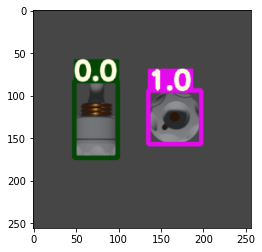

In [28]:
labels = txt2label("./out/000000.txt")
rgb_data = png2rgb("./out/000000rgb.png")

plot_bbox(rgb_data, labels)

fig = plt.figure()
rgb_data = rgb_data[:, :, ::-1]
plt.imshow(rgb_data)
plt.show()
